In [2]:
import sys, os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split



import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_repo = os.getcwd()
data_path = os.path.join(main_repo, 'MovieGenre', 'content', 'sorted_movie_posters_paligema')
registers = os.listdir(data_path)

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, labels, img_path, transform=True):

        self.labels = labels
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):

        img_path = self.img_path[idx]
        image = Image.open(img_path)

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, img_path, label

In [4]:
train_paths, test_paths = [], []
train_labels, test_labels = [], []

for (i, register) in enumerate(registers):

    register_path = os.path.join(data_path, register)
    register_images = [os.path.join(register_path, file) for file in os.listdir(register_path)]
    train_img, test_img = train_test_split(register_images, test_size=0.2)
    
    train_paths += train_img
    test_paths += test_img
    train_labels += [i] * len(train_img)
    test_labels += [i] * len(test_img)

In [5]:
initial_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = CustomImageDataset(labels=train_labels, img_path=train_paths, transform=initial_transform)
test_dataset = CustomImageDataset(labels=test_labels, img_path=test_paths, transform=initial_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train size", len(train_dataset), "Test size", len(test_dataset))

Train size 4297 Test size 1078


In [6]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

#for param in model.layer4.parameters():
#    param.requires_grad = True

num_classes = len(registers)
model.fc = torch.nn.Linear(in_features=512, out_features=num_classes)

/home/baba/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/baba/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Training function
def train(model, criterion, optimizer, train_loader):
    model.to(device)
    model.train()
    
    train_losses = []
    train_acc = []

    for inputs, _, targets in tqdm(train_loader, desc="Training", unit="batch"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_losses.append(loss.item())
        
        # Compute accuracy
        _, preds = torch.max(outputs, 1)
        correct = (preds == targets).sum().item()
        acc = correct / targets.size(0)
        train_acc.append(acc)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return np.mean(train_losses), np.mean(train_acc)


# Test function
def test(model, criterion, test_loader):
    model.eval()
    
    test_losses = []
    test_acc = []
    
    with torch.no_grad():
        for inputs, _, targets in tqdm(test_loader, desc="Testing", unit="batch"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_losses.append(loss.item())
            
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            correct = (preds == targets).sum().item()
            acc = correct / targets.size(0)
            test_acc.append(acc)
            
    return np.mean(test_losses), np.mean(test_acc)

Epoch 1 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  6.27batch/s]


-----------------------------------
Train loss: 1.9634 - Test loss: 1.7910
Test accuracy: 39.50%
-----------------------------------

Epoch 2 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  5.81batch/s]


-----------------------------------
Train loss: 1.6831 - Test loss: 1.6666
Test accuracy: 42.10%
-----------------------------------

Epoch 3 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  6.06batch/s]


-----------------------------------
Train loss: 1.5952 - Test loss: 1.6402
Test accuracy: 43.66%
-----------------------------------

Epoch 4 of 5


Testing: 100%|██████████| 17/17 [00:03<00:00,  5.59batch/s]


-----------------------------------
Train loss: 1.5420 - Test loss: 1.6100
Test accuracy: 44.32%
-----------------------------------

Epoch 5 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  5.86batch/s]


-----------------------------------
Train loss: 1.4954 - Test loss: 1.6169
Test accuracy: 46.24%
-----------------------------------



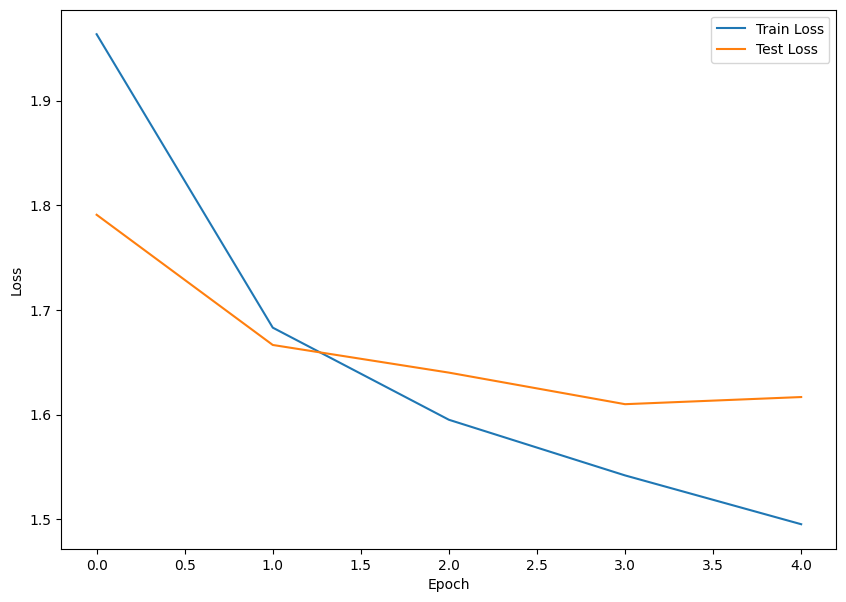

In [8]:
# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5

# Training loop
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    test_loss, test_accuracy = test(model, criterion, test_loader)
    print("-----------------------------------")
    print(f"Train loss: {train_loss:.4f} - Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    print("-----------------------------------")
    print()
   
torch.save(model.state_dict(), "model")

# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
for param in model.parameters():
    param.requires_grad = True

Epoch 1 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  5.96batch/s]


-----------------------------------
Train loss: 1.4506 - Test loss: 1.5708
Test accuracy: 46.80%
-----------------------------------

Epoch 2 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  5.81batch/s]


-----------------------------------
Train loss: 1.2897 - Test loss: 1.5475
Test accuracy: 46.91%
-----------------------------------

Epoch 3 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  5.92batch/s]


-----------------------------------
Train loss: 1.1896 - Test loss: 1.5444
Test accuracy: 46.36%
-----------------------------------

Epoch 4 of 5


Testing: 100%|██████████| 17/17 [00:02<00:00,  5.91batch/s]


-----------------------------------
Train loss: 1.0776 - Test loss: 1.5371
Test accuracy: 46.84%
-----------------------------------

Epoch 5 of 5


Testing: 100%|██████████| 17/17 [00:03<00:00,  5.36batch/s]


-----------------------------------
Train loss: 0.9817 - Test loss: 1.5372
Test accuracy: 46.75%
-----------------------------------



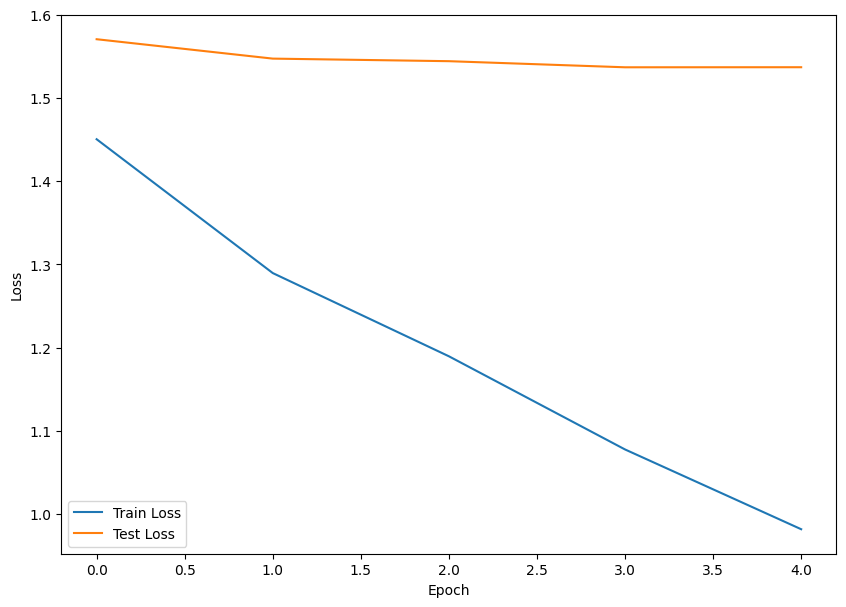

In [10]:
# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
train_losses, test_losses = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    test_loss, test_accuracy = test(model, criterion, test_loader)
    print("-----------------------------------")
    print(f"Train loss: {train_loss:.4f} - Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    print("-----------------------------------")
    print()
   
torch.save(model.state_dict(), "model")

# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
torch.save(model.state_dict(), main_repo + '/model.pth')